In [1]:
# from variable500grid import *
# from variable2000grid50sensor import*
from global_variable import*

In [2]:
import random
import networkx as nx
import math
import itertools    
import matplotlib.pyplot as plt
import ast
import numpy as np
import operator
from sklearn.cluster import KMeans
from collections import defaultdict
import pandas as pd
from matplotlib import pyplot as plt
from gurobipy import *
import gurobipy as gp

In [3]:
# with open('sensor_for_large_Grid2000_50sensorlistonlyfeb13real.txt', 'r') as f:
#     sensor = ast.literal_eval(f.read())

In [4]:
with open('test500grid10sensortest4.txt', 'r') as f:
    sensor = ast.literal_eval(f.read())

In [5]:
length_of_grid

500

In [6]:
 sensor=sorted(sensor)

In [7]:
sensor

[(24, 318),
 (125, 296),
 (127, 330),
 (174, 337),
 (268, 43),
 (338, 24),
 (352, 119),
 (378, 36),
 (379, 262),
 (411, 275)]

In [8]:
s=[list(i) for i in sensor]

In [9]:
X=np.array(s)

## function just to calculate distance between two pdp points

In [10]:
def distance(points,i,j):
    x=points[i][0]-points[j][0]
    y=points[i][1]-points[j][1]
    return math.sqrt(x*x+y*y)

## Function to determine the pdp position in the grid

In [11]:
def calculate_Pdp_positions(length_of_grid,transmission_range):
    pdp_positions={}
    k=0
    for c_1 in np.arange(length_of_grid/(transmission_range*math.sqrt(2))):
        for c_2 in np.arange(length_of_grid/(transmission_range*math.sqrt(2))):
            pdp_positions[k]=(c_1*transmission_range*math.sqrt(2),c_2*transmission_range*math.sqrt(2))
            k=k+1
    return pdp_positions

In [12]:
pdp_positions=calculate_Pdp_positions(length_of_grid,transmission_range)

## Function to create the trip graph

In [13]:
def create_trip_graph():
    G=nx.Graph()
    distance_between_pdp={}
    for i in range(len(pdp_positions)):
        G.add_node('pdp{}'.format(i),pos=pdp_positions[i])
    for u in range(len(pdp_positions)):
        for v in range(len(pdp_positions)):
            wt=distance(pdp_positions,u,v)
            G.add_edge('pdp{}'.format(u),'pdp{}'.format(v),weight=wt)
            distance_between_pdp[(u,v)]=wt
    return G,distance_between_pdp

In [14]:
trip_graph,distance_between_pdp=create_trip_graph()

## This function calculates the pdp with the minimum distance betweeen the cluster center

In [15]:
def calculate_min_pdp_distance_with_cluster_center(c_centers,pdp_positions):
    """
    Function to calculate the nearest pdp_position to the cluster center 
    """
    new_dict={}
    for i in c_centers:
        temp={}
        for p,value in pdp_positions.items():
            arr=np.array(value)
            #print(arr)
            dist=np.linalg.norm(i-arr)
            temp[p]=dist
        #print(temp)
        print(min(temp.items(),key=operator.itemgetter(1))[0])
        print(min(temp.items(),key=operator.itemgetter(1))[1])
        print("******")
        new_dict[tuple(i)]=min(temp.items(),key=operator.itemgetter(1))[0]

    return new_dict

In [16]:
K=nx.DiGraph()

In [17]:
for i in range(len(sensor)):
    K.add_node('sensor{}'.format(i),pos=sensor[i])

In [18]:
def calulate_distance_between_each_sensors_and_assign_weight(points,K):
    distance_sensors={}
    M=K
    k=0
    edge_weight=1
    for i in range(len(points)):
        for j in range(len(points)):
            euclidean_distance=distance(points,i,j)
            if i!=j:
                #M.add_edge("sensor{}".format(i),"sensor{}".format(j))

                
                if euclidean_distance<=transmission_range:
                    #if M.has_edge('sensor{}'.format(i),'sensor{}'.format(j))!=True:
                    M.add_edge("sensor{}".format(i),"sensor{}".format(j))

                    M["sensor{}".format(i)]["sensor{}".format(j)]['weight']=1

                    distance_sensors[i,j]=(euclidean_distance,edge_weight)
#                 else:
#                     M["sensor{}".format(i)]["sensor{}".format(j)]['weight']=100
#                     distance_sensors[i,j]=(euclidean_distance,100)
#             k=k+1
    return distance_sensors,M

In [19]:
euclidean_distance_between_sensor,L=calulate_distance_between_each_sensors_and_assign_weight(sensor,K)

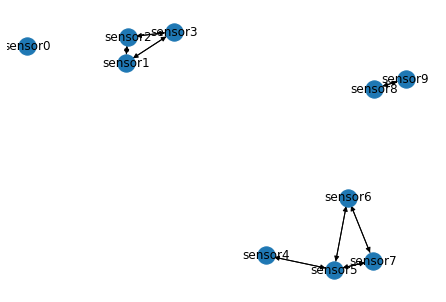

In [20]:
nx.draw(L,nx.get_node_attributes(L,'pos'),with_labels=True)

In [21]:
def distance_pdp_sensors(pdp_positions,sensor,u,v):
    x=pdp_positions[u][0]-sensor[v][0]
    y=pdp_positions[u][1]-sensor[v][1]
    return math.sqrt(x*x+y*y)

## Function that is used for creating the conncectivity graph

In [22]:
def connectivity_graph(pdp_positions,sensor,K):
    J=K
    distance_pdp_each_sensor={}
    k=0
    weight=1
    for i in range(len(pdp_positions)):
        J.add_node('pdp{}'.format(i),pos=pdp_positions[i])
    for u in range(len(pdp_positions)):
        for v in range(len(sensor)):
            euclidean_distance_between_pdp_sensor=distance_pdp_sensors(pdp_positions,sensor,u,v)
            J.add_edge("pdp{}".format(u),"sensor{}".format(v))
            
            if euclidean_distance_between_pdp_sensor<=transmission_range:
                #J.add_edge("pdp{}".format(u),"sensor{}".format(v))
                #if J.has_edge('pdp{}'.format(i),'sensor{}'.format(j))!=True:
                    #J.add_edge("pdp{}".format(u),"sensor{}".format(v))
               
                
                J["pdp{}".format(u)]["sensor{}".format(v)]['weight']=1
                distance_pdp_each_sensor[u,v]=euclidean_distance_between_pdp_sensor,weight
            else:
                J["pdp{}".format(u)]["sensor{}".format(v)]['weight']=100
                distance_pdp_each_sensor[u,v]=euclidean_distance_between_pdp_sensor,100
#            k=k+1
    return distance_pdp_each_sensor,J

In [23]:
distance_between_pdp_to_each_sensor,N=connectivity_graph(pdp_positions,sensor,L)

# Here it finds the shortest distance between each pdp and 

In [24]:
k=0
arc_length={}
shortest_path={}
for i in range(len(pdp_positions)):
    for j in range(len(sensor)):
        if N.has_edge('pdp{}'.format(i),'sensor{}'.format(j)):
            shortest_path[i,j]=nx.shortest_path(N,source='pdp{}'.format(i),target='sensor{}'.format(j),
                                              weight='weight',method='dijkstra')
            arc_length[i,j]=nx.dijkstra_path_length(N,'pdp{}'.format(i),'sensor{}'.format(j))
            
           
        else:
            shortest_path[i,j]=0

In [25]:
new_zipped=dict(zip(arc_length.items(),shortest_path.values()))

In [26]:
def spanning_tree_collecting_time(pdp):
    """This function defines which sensors are connected with the desired pdp"""
    """
    return list
    """
    sensor_subset=[]
    for key,value in new_zipped.items():
        if key[0][0]==pdp:
            if key[1]!=100:
                #print(i)
                sensor_subset.append(key[0][1])
    return sensor_subset

In [27]:
def to_check_the_minimum_hops_between_the_pdp_and_sensor(spanning_tree):
    """In this function we check which sensor can send data to the pdp with minimum hops
    for example if sensor2 is connected with pdp10 with  hop distance with 2 and same sensor2 is connected with 
    pdp11 with hop distance 4 then we assume that sensor2 will send data to the drone when drone is at pdp10 since 
    it has minimum hop distance"""
    subset2=spanning_tree
    for key,value in subset2.items():
        for key1,value1 in subset2.items():
            if key!=key1:
                for i in value:
                    for j in value1:
                        if i==j:
                            #print(i)
                            #s=get_number(i)
                            if nx.dijkstra_path_length(N,'pdp{}'.format(key),'sensor{}'.format(i))>nx.dijkstra_path_length(N,'pdp{}'.format(key1),'sensor{}'.format(i)):
                                subset2[key].remove(i)
                            else:
                                subset2[key1].remove(j)
    return subset2

In [28]:
def create_spanning_tree_for_tour(tour):
    sensor_subset={}
    for i in tour:
        sensor_subset[i]=spanning_tree_collecting_time(i)
    correct_sensor_subset=to_check_the_minimum_hops_between_the_pdp_and_sensor(sensor_subset)
    return correct_sensor_subset

In [29]:
def check_all_sensor_can_send_data(checked_sensor_arc):
    """The main aim of creating this function was to check whether all the sensors are connected to the pdps in the route
    of drone tour.For example we have pdp10 and pdp7 in our route.ie Route=[10 7].We create spanning tree for the both 
    the pdps and check whether all the sensors are connected or not.If all the sensors are not connected in the combined
    spanning tree calculated with the pdps of the Route"""
    s=[]
    for key,values in checked_sensor_arc.items():
        s=list(set().union(s,values))
    if len(s)==len(sensor): # before there was only s==sensor but it was wrong as s is list and sensor is a list of tuple
        return 1
    else:
        return 0
    

In [30]:
def determine_collecting_time(checked_sensor_arc):
    """After checking whether all the sensor can send data while the drone makes a trip in the way as
    described in the Route.We assign collecting time as infinite or call the collecting time function"""
    value=check_all_sensor_can_send_data(checked_sensor_arc)
    if value==1:
        t_collecting=calculate_collecting_time(checked_sensor_arc)
    if value==0:
        t_collecting=math.inf
    return t_collecting

In [31]:
def check_all_sensor_can_send_data(checked_sensor_arc):
    """The main aim of creating this function was to check whether all the sensors are connected to the pdps in the route
    of drone tour.For example we have pdp10 and pdp7 in our route.ie Route=[10 7].We create spanning tree for the both 
    the pdps and check whether all the sensors are connected or not.If all the sensors are not connected in the combined
    spanning tree calculated with the pdps of the Route"""
    s=[]
    for key,values in checked_sensor_arc.items():
        s=list(set().union(s,values))
    if len(s)==len(sensor): # before there was only s==sensor but it was wrong as s is list and sensor is a list of tuple
        return 1
    else:
        return 0
    

In [32]:
def calculate_collecting_time(checked_sensor_arc):
    
    dict_={}
    for key,values in checked_sensor_arc.items():
        weight=0
        if values!=[]:
            for j in values:
                for key1,values1 in new_zipped.items():
                    if key1[0]==(key,j):
                        #print(key1[1])
                        weight=weight+key1[1]
                        t_collecting=(data_rate/bandwidth)*weight
        dict_[key]=t_collecting
    return dict_
    

In [33]:
def calc_cluster_number(sensor):
    M=1000*1000
    no_of_vehicles=2
    K=3
    
    for i in range(1,len(sensor)+1):
        new_dict={}
        kmeans=KMeans(n_clusters=i,random_state=1000)
        kmeans.fit(X)
        c_centers=tuple(kmeans.cluster_centers_)
        for j in c_centers:
            temp={}
            for p,value in pdp_positions.items():
                arr=np.array(value)
                dist=np.linalg.norm(j-arr)
                temp[p]=dist
#           print(temp)
            new_dict[tuple(j)]=min(temp.items(),key=operator.itemgetter(1))[0]
        subset={}
        print(new_dict)
        for key,values in new_dict.items():
            subset[values]=spanning_tree_collecting_time(values)
        checked=to_check_the_minimum_hops_between_the_pdp_and_sensor(subset)
        check=check_all_sensor_can_send_data(checked)
        if check==1:
            print("i am here")
            df_=calculate_collecting_time(checked)
            print(df_)
            break
    coordinates=[]
    for key,values in df_.items():
        for k,v in pdp_positions.items():
            if key==k:
                l=list(v)
                coordinates.append(l)
    
    
    
    return coordinates
        
        
            

In [34]:
%%time
coordinates=calc_cluster_number(sensor)

{(257.6, 204.0): 9}
{(354.3333333333333, 126.5): 13, (112.5, 320.25): 6}
{(334.0, 55.5): 8, (112.5, 320.25): 6, (395.0, 268.5): 14}
{(334.0, 55.5): 8, (24.0, 318.0): 2, (142.0, 321.0): 6, (395.0, 268.5): 14}
i am here
{8: 15.0, 2: 2.5, 6: 7.5, 14: 5.0}
Wall time: 261 ms


In [35]:
# coordinates=[]
# for key,values in o.items():
#     for k,v in pdp_positions.items():
#         if key==k:
#             l=list(v)
#             coordinates.append(l)
    

In [36]:
coordinates

[[282.842712474619, 0.0],
 [0.0, 282.842712474619],
 [141.4213562373095, 282.842712474619],
 [424.26406871192853, 282.842712474619]]

In [37]:
coordinates=[[0,0]]+coordinates

In [38]:
M=1000*1000

In [39]:
n = len(coordinates)

In [40]:
n

5

In [41]:
L=n

In [42]:
coordinates=np.array(coordinates)

In [43]:
depot, customers = coordinates[0, :], coordinates[1:, :]

In [44]:
no_of_vehicles=2

set minimum number of customers to be visited by each drone

In [45]:
# K=n//no_of_vehicles-1

In [46]:
K=(n-1)//no_of_vehicles

In [47]:
K

2

In [48]:
dist_matrix = np.empty([n, n])

In [49]:
m = Model("MVRP")

Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-20


In [50]:
for i in range(n):
    for j in range(n):
        dist_matrix[i, j] = np.sqrt((coordinates[i][0] - coordinates[j][0]) ** 2 + (coordinates[i][1] - coordinates[j][1]) ** 2)
        if i==j:
            dist_matrix[i,j]=M
        continue

In [51]:
x={}

In [52]:
for i in range(n):
    for j in range(n):
        for k in range(no_of_vehicles):
            x[i, j,k] = m.addVar(vtype=GRB.BINARY, name="x%d,%d,%d" % (i, j,k))
m.update()

In [53]:
# for i in range(n):
#     x[i, i].ub = 0

In [54]:
u_vars = {}
for i in range(n):
    u_vars[i] = m.addVar(lb=0, ub=L, vtype=gurobipy.GRB.INTEGER, name='u' + str(i))
m.update()

new added line

In [55]:
m.addConstr(gp.quicksum(gp.quicksum(x[0,j,k] for j in range(1,n))for k in range(no_of_vehicles))==no_of_vehicles)

<gurobi.Constr *Awaiting Model Update*>

In [56]:
m.addConstr(gp.quicksum(gp.quicksum(x[j,0,k] for j in range(1,n))for k in range(no_of_vehicles))==no_of_vehicles)

<gurobi.Constr *Awaiting Model Update*>

In [57]:
for i in range(1, n):
    m.addConstr(gp.quicksum(gp.quicksum(x[i, j,k] for j in range(n))for k in range(no_of_vehicles)) == 1)

In [58]:
# for k in range(no_of_vehicles):
#     for i in range(1, n):
#         m.addConstr(gp.quicksum(x[i, j,k] for j in range(n)) == 1)

In [59]:

for j in range(1, n):
    m.addConstr(gp.quicksum(gurobipy.quicksum(x[i, j,k] for i in range(n))for k in range(no_of_vehicles)) == 1)

In [60]:
# for k in range(no_of_vehicles):
#     for j in range(1, n):
#         m.addConstr(gurobipy.quicksum(x[i, j,k] for i in range(n)) == 1)

This constraint is new for route continuity

In [61]:
for k in range(no_of_vehicles):
    for i in range(n):
        m.addConstr(gp.quicksum(x[i,j,k] for j in range(n) )-gp.quicksum(x[j,i,k] for j in range(n) )==0)

In [62]:
for i in range(1,n):
    m.addConstr(u_vars[i]+(L-2)*gp.quicksum(x[0,i,k] for k in range(no_of_vehicles))-gp.quicksum(x[i,0,k] for k in range(no_of_vehicles))<=L-1)

In [63]:
for i in range(1,n):
    m.addConstr(u_vars[i]+gp.quicksum(x[0,i,k] for k in range(no_of_vehicles))+(2-K)*gp.quicksum(x[i,0,k] for k in range(no_of_vehicles))>=2)

In [64]:
for i in range(1,n):
    m.addConstr(gp.quicksum(x[0,i,k] for k in range(no_of_vehicles))+gp.quicksum(x[i,0,k] for k in range(no_of_vehicles))<=1)

In [65]:
for i in range(1,n):
    for j in range(1,n):
        if i !=j:
            m.addConstr(u_vars[i]-u_vars[j]+L*gp.quicksum(x[i,j,k] for k in range(no_of_vehicles))+(L-2)*gp.quicksum(x[j,i,k] for k in range (no_of_vehicles))<=L-1)

## new constraint for mTSP

In [66]:
# for k in range(no_of_vehicles):
#     m.addConstr(gp.quicksum(x[k,j,k] for j in range(1,n))-gp.quicksum(x[j,k,k] for j in range(1,n))==0)

In [67]:
# for j in range(1,n):
#     m.addConstr(gp.quicksum(x[k,j,k] for k in range(no_of_vehicles))+gp.quicksum(gp.quicksum(x[i,j,k] for i in range(1,n))for k in range(no_of_vehicles))==1)

In [68]:
# for j in range(1,n):
#     for k in range(no_of_vehicles):
#         m.addConstr(x[k,j,k]+gp.quicksum(x[i,j,k] for i in range(1,n))-x[j,k,k]-gp.quicksum(x[j,i,k] for i in range(1,n))==0)

In [69]:
# for i in range(1,n):
#     m.addConstr(u_vars[i]+(L-2)*gp.quicksum(x[k,i,k] for k in range(no_of_vehicles))-gp.quicksum(x[i,k,k] for k in range(no_of_vehicles))<=1)

In [70]:
# for i in range(1,n):
#     m.addConstr(u_vars[i]+gp.quicksum(x[k,i,k] for k in range(no_of_vehicles))+(2-K)*gp.quicksum(x[i,k,k] for k in range(no_of_vehicles))>=2)

In [71]:
# for i in range(1,n):
#     m.addConstr(gp.quicksum(x[k,i,k] for k in range(no_of_vehicles))+gp.quicksum(x[i,k,k] for k in range(no_of_vehicles))<=1)

In [72]:
m.update()

In [73]:
z=m.addVar(vtype=GRB.CONTINUOUS,name='z')

In [74]:
for k in range(no_of_vehicles):
    m.addConstr(quicksum(quicksum(x[(i, j,k)]*dist_matrix[(i, j)] for j in range(n)) for i in range(n))<=z)

In [75]:
    m.setObjective(z,GRB.MINIMIZE)
    m.optimize()
m.write("coll1.lp")

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 46 rows, 56 columns and 348 nonzeros
Model fingerprint: 0x2a9cab3f
Variable types: 1 continuous, 55 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 1217.0087326
Presolve removed 0 rows and 11 columns
Presolve time: 0.00s
Presolved: 46 rows, 45 columns, 314 nonzeros
Variable types: 1 continuous, 44 integer (40 binary)

Root relaxation: objective 9.247321e+02, 34 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  924.73213    0    9 1217.00873  924.73213  24.0%     -    0s
H    0     0                    1108.9724299 

In [76]:
# %%time
# m._vars = x
# m._uvars = u_vars
# # m.params.OutputFlag = int(kwargs.get('output_flag', 0))
# # m.params.TimeLimit = float(kwargs.get('time_limit', 60.0))
# m.setObjective(quicksum(quicksum(x[(i, j)]*dist_matrix[(i, j)] for j in range(n)) for i in range(n)),GRB.MINIMIZE)
# m.optimize()
# m.write("coll.lp")

In [77]:
print('\n minimum distance: %g' % m.objVal)


 minimum distance: 1108.97


In [78]:
m.printAttr('X')


    Variable            X 
-------------------------
      x0,3,0            1 
      x0,4,1            1 
      x1,0,1            1 
      x2,0,0            1 
      x3,2,0            1 
      x4,1,1            1 
          u1            2 
          u2            2 
          u3            1 
          u4            1 
           z      1108.97 


In [79]:
from_node = []
to_node = np.empty([n, n])

In [80]:
for v in m.getVars():
    from_node.append(v.x)

In [81]:
for i in range(n):
    for j in range(n):
        to_node[i, j] = from_node[n * i + j]

In [82]:
print('\nDistance Matrix (dij):\n', pd.DataFrame(dist_matrix).astype('int64'))
print('\nDecision (Xij):\n', pd.DataFrame(to_node).astype('int64'))


Distance Matrix (dij):
          0        1        2        3        4
0  1000000      282      282      316      509
1      282  1000000      400      316      316
2      282      400  1000000      141      424
3      316      316      141  1000000      282
4      509      316      424      282  1000000

Decision (Xij):
    0  1  2  3  4
0  0  0  0  0  0
1  0  1  0  0  1
2  0  1  0  0  0
3  0  0  0  0  0
4  1  0  0  0  0


In [83]:
solution = m.getAttr('X', x)
solution

{(0, 0, 0): 0.0,
 (0, 0, 1): 0.0,
 (0, 1, 0): 0.0,
 (0, 1, 1): 0.0,
 (0, 2, 0): 0.0,
 (0, 2, 1): 0.0,
 (0, 3, 0): 1.0,
 (0, 3, 1): 0.0,
 (0, 4, 0): 0.0,
 (0, 4, 1): 1.0,
 (1, 0, 0): 0.0,
 (1, 0, 1): 1.0,
 (1, 1, 0): 0.0,
 (1, 1, 1): 0.0,
 (1, 2, 0): 0.0,
 (1, 2, 1): 0.0,
 (1, 3, 0): 0.0,
 (1, 3, 1): 0.0,
 (1, 4, 0): 0.0,
 (1, 4, 1): 0.0,
 (2, 0, 0): 1.0,
 (2, 0, 1): 0.0,
 (2, 1, 0): 0.0,
 (2, 1, 1): 0.0,
 (2, 2, 0): 0.0,
 (2, 2, 1): 0.0,
 (2, 3, 0): 0.0,
 (2, 3, 1): 0.0,
 (2, 4, 0): 0.0,
 (2, 4, 1): 0.0,
 (3, 0, 0): 0.0,
 (3, 0, 1): 0.0,
 (3, 1, 0): 0.0,
 (3, 1, 1): 0.0,
 (3, 2, 0): 1.0,
 (3, 2, 1): 0.0,
 (3, 3, 0): 0.0,
 (3, 3, 1): 0.0,
 (3, 4, 0): 0.0,
 (3, 4, 1): 0.0,
 (4, 0, 0): 0.0,
 (4, 0, 1): 0.0,
 (4, 1, 0): 0.0,
 (4, 1, 1): 1.0,
 (4, 2, 0): 0.0,
 (4, 2, 1): 0.0,
 (4, 3, 0): 0.0,
 (4, 3, 1): 0.0,
 (4, 4, 0): 0.0,
 (4, 4, 1): 0.0}

In [84]:
selected=[]
for key,val in solution.items():
    if val>0:
        selected.append(key)
        print(key)

(0, 3, 0)
(0, 4, 1)
(1, 0, 1)
(2, 0, 0)
(3, 2, 0)
(4, 1, 1)


In [85]:
selected

[(0, 3, 0), (0, 4, 1), (1, 0, 1), (2, 0, 0), (3, 2, 0), (4, 1, 1)]

In [96]:
selected[0][0]

0

In [86]:
from collections import defaultdict
values32=defaultdict(list)

In [87]:
Depot= [x for x in range(no_of_vehicles)]

In [100]:
Depot=[0]

In [103]:
subtour= defaultdict(list)

for i in range(no_of_vehicles):
    subtour[i]=[]
    next_city=selected[i][0]
    finished=False
    while not finished:
        for j in range(i,len(selected)):
            if selected[j][0]==next_city:
                print(next_city)
                subtour[i].append(next_city)
                print(next_city)
                next_city=selected[j][1]
                break
        if next_city in Depot:
            subtour[i].append(next_city)
            finished=True

0
0
3
3
2
2
0
0
4
4
1
1


In [104]:
subtour

defaultdict(list, {0: [0, 3, 2, 0], 1: [0, 4, 1, 0]})

In [106]:
dist_matrix = np.empty([n, n])

In [107]:
len(dist_matrix)

5

In [109]:

for i in range(n):
    for j in range(n):
        
        dist_matrix[i,j]=np.linalg.norm(np.array(coordinates[i])-np.array(coordinates[j]))

In [110]:
dist_matrix

array([[  0.        , 282.84271247, 282.84271247, 316.22776602,
        509.90195136],
       [282.84271247,   0.        , 400.        , 316.22776602,
        316.22776602],
       [282.84271247, 400.        ,   0.        , 141.42135624,
        424.26406871],
       [316.22776602, 316.22776602, 141.42135624,   0.        ,
        282.84271247],
       [509.90195136, 316.22776602, 424.26406871, 282.84271247,
          0.        ]])

In [111]:
sub_route_total_distance = {}

for i in range(no_of_vehicles):
    # print('\n')
    sub_route_total_distance[i] = 0
    for j in range(len(subtour[i])):
        if j<len(subtour[i])-1:
            
            cur_index = subtour[i][j]
            next_index=subtour[i][j+1]
            print('dist[%d,%d]=%d' % (cur_index, next_index, dist_matrix[cur_index][next_index]))
            sub_route_total_distance[i] += dist_matrix[cur_index][next_index]
print('all sub route total distance sum:')
print(sub_route_total_distance)

dist[0,3]=316
dist[3,2]=141
dist[2,0]=282
dist[0,4]=509
dist[4,1]=316
dist[1,0]=282
all sub route total distance sum:
{0: 740.4918347287664, 1: 1108.9724298507354}


In [112]:
tv=0
for v,k in sub_route_total_distance.items():
    tv=tv+k
print(tv)

1849.4642645795018


In [115]:
X=[]
Y=[]
for i,value in enumerate (coordinates):
    X.append(coordinates[i][0])
    Y.append(coordinates[i][1])

In [116]:
X

[0.0, 282.842712474619, 0.0, 141.4213562373095, 424.26406871192853]

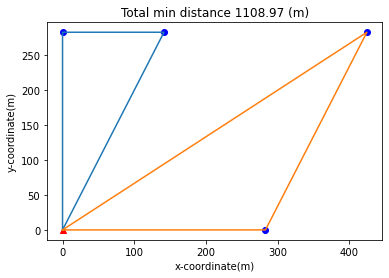

In [117]:
plt.figure()
plt.scatter(X[len(Depot):], Y[len(Depot):], marker='o', color='blue')
plt.scatter(X[0:len(Depot)], Y[0:len(Depot)], marker='^', color='red')
plt.xlabel('x-coordinate(m)')
plt.ylabel('y-coordinate(m)')
plt.title('Total min distance %g (m)' % m.objVal)
# plt.plot([XX1, XX2], [YY1, YY2])
for index in subtour:
    route_list = subtour[index]
    x = []
    y = []
    for i in route_list:
        x.append(X[i])
        y.append(Y[i])
    plt.plot(x, y)
plt.show()

In [118]:
subtour

defaultdict(list, {0: [0, 3, 2, 0], 1: [0, 4, 1, 0]})